# Assiociation rules

- Frequent patterns extraction with different values of support and different types (i.e. frequent, close, maximal), (6 points)
- Discussion of the most interesting frequent patterns and analyze how changes the number of patterns w.r.t. the min_sup parameter (7 points)
- Association rules extraction with different values of confidence (6 points)
- Discussion of the most interesting rules and analyze how changes the number of rules w.r.t. the min_conf parameter, histogram of rules' confidence and lift (7 points)
- Use the most meaningful rules to replace missing values and evaluate the accuracy (2 points)
- Use the most meaningful rules to predict the target variable and evaluate the accuracy (2 points)

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import platform
import os
from sklearn.utils import resample

Scarichiamo il pacchetto fim giusto, guardiamo che macchina stiamo usando e che archiettura ha

In [94]:
platform.machine()

'x86_64'

In [95]:
platform.platform()

'Linux-5.3.0-24-generic-x86_64-with-debian-buster-sid'

Scarichiamo quindi la libreria giusta da http://www.borgelt.net/pyfim.html e la mettiamo con gli altri file

In [96]:
files = [f for f in os.listdir('.') if os.path.isfile(f)]
for f in files:
    print(f)

README.md
caravana_data_ar.ipynb
caravana_data_clustering_KMeans.ipynb
.gitignore
fim.so
Caravana_DBSCAN.ipynb
Guidelines.pdf
caravana_classification.ipynb
caravana_data_understanding.ipynb
caravana_data_preparation.ipynb
caravana_data_clustering_hierarchical.ipynb
LICENSE
knime workflow 123.knar.knwf


In [97]:
from fim import apriori

## Data Preprocessing

### Lettura Dataset

In [98]:
data = pd.read_csv('data/training_ready_no_regression.csv')
data.head()

,RefId,IsBadBuy,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple,Doors,USRegion
0,326,1,10/25/2010,ADESA,2,KIA,SPECTRA,EX,SEDAN EX,BLUE,...,7535.0,9605.0,10650.0,FL,6100.0,0,533,SPECTRA,4D,South
1,42991,0,5/27/2009,MANHEIM,3,DODGE,STRATUS V6 2.7L V6 M,SXT,SEDAN SXT FFV,SILVER,...,6461.0,6418.0,7478.0,FL,4000.0,0,1630,STRATUS,4D,South
2,55273,0,3/18/2010,OTHER,2,DODGE,CALIBER,SE,WAGON,BLACK,...,8102.0,10721.0,11350.0,OK,7500.0,0,693,CALIBER,4D,South
3,29058,0,6/8/2009,OTHER,4,FORD,FREESTAR FWD V6 3.9L,S,PASSENGER 3.9L,BROWN,...,6658.0,5702.0,7691.0,AZ,4725.0,0,1633,FREESTAR,NaN,West
4,34991,0,3/4/2009,MANHEIM,4,CHRYSLER,TOWN & COUNTRY FWD V,BAS,MINIVAN 3.3L,BLUE,...,6811.0,6300.0,7856.0,TX,5670.0,0,1623,TOWN & COUNTRY,NaN,South


In [99]:
data.isnull().sum()

RefId                                   0
IsBadBuy                                0
PurchDate                               0
Auction                                 0
VehicleAge                              0
Make                                    0
Model                                   0
Trim                                    0
SubModel                                0
Color                                   0
Transmission                            0
WheelType                               0
VehOdo                                  0
Nationality                             0
Size                                    0
TopThreeAmericanName                    0
MMRAcquisitionAuctionAveragePrice       0
MMRAcquisitionAuctionCleanPrice         0
MMRAcquisitionRetailAveragePrice        0
MMRAcquisitonRetailCleanPrice           0
MMRCurrentAuctionAveragePrice           0
MMRCurrentAuctionCleanPrice             0
MMRCurrentRetailAveragePrice            0
MMRCurrentRetailCleanPrice        

### Scelta attributi

In [100]:
# Eliminazioni dati rindondanti
del data['MMRCurrentRetailCleanPrice']
del data['MMRCurrentRetailAveragePrice']
del data['MMRCurrentAuctionCleanPrice']
del data['MMRCurrentAuctionAveragePrice']
del data['MMRAcquisitonRetailCleanPrice']
del data['MMRAcquisitionAuctionAveragePrice']
del data['MMRAcquisitionAuctionCleanPrice']
del data['MMRAcquisitionRetailAveragePrice']

del data['Model']
del data['Nationality']
del data['TopThreeAmericanName']
del data['VNST']
del data['SubModel']
del data['Size']
del data['Make']

# Eliminazione dati irrilevanti
del data['RefId']
del data['PurchDate'] # ?
del data['IsOnlineSale']

In [101]:
data.head()

,IsBadBuy,Auction,VehicleAge,Trim,Color,Transmission,WheelType,VehOdo,VehBCost,WarrantyCost,ModelSimple,Doors,USRegion
0,1,ADESA,2,EX,BLUE,AUTO,COVERS,61184,6100.0,533,SPECTRA,4D,South
1,0,MANHEIM,3,SXT,SILVER,AUTO,COVERS,92383,4000.0,1630,STRATUS,4D,South
2,0,OTHER,2,SE,BLACK,AUTO,COVERS,45965,7500.0,693,CALIBER,4D,South
3,0,OTHER,4,S,BROWN,AUTO,COVERS,80169,4725.0,1633,FREESTAR,NaN,West
4,0,MANHEIM,4,BAS,BLUE,AUTO,ALLOY,77372,5670.0,1623,TOWN & COUNTRY,NaN,South


### Eliminazione Outliers

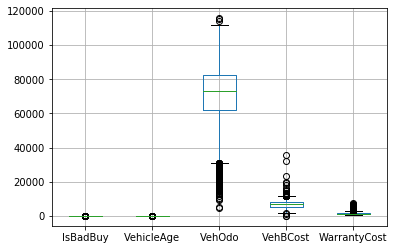

In [102]:
data.boxplot()

In [103]:
data_original = data.copy(deep=True)

not_num = data[['IsBadBuy', 'VehicleAge']]
del data['IsBadBuy']
del data['VehicleAge']

In [104]:
tot = data.shape[0]
# identify outliers with interquartile range
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
k = 10
data = data[~((data < (Q1 - (k * IQR))) | (data > (Q3 + (k * IQR)))).any(axis=1)]
tot_no_outlier = data.shape[0]

print('Outlier removed: '+str(tot-tot_no_outlier))

Outlier removed: 1


In [105]:
data['IsBadBuy'] = not_num['IsBadBuy']
data['VehicleAge'] = not_num['VehicleAge']

In [106]:
data['IsBadBuy'].unique()

array([1, 0])

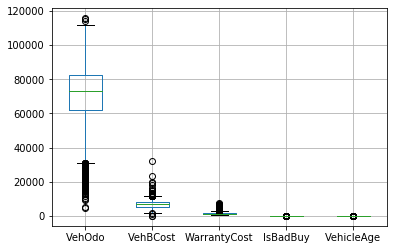

In [107]:
data.boxplot()

### Discretizzazione attributi continui TODO: Warranty cost fa schifo

Abbiamo tenuto 3 valori continui da discretizzare, guardiamone la distribuzione

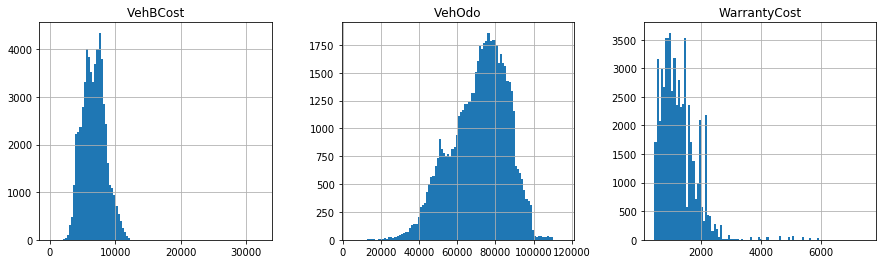

In [108]:
data[['VehOdo', 'VehBCost', 'WarrantyCost']].hist(bins=100, figsize=(15, 4), layout=(1,3))
plt.show()

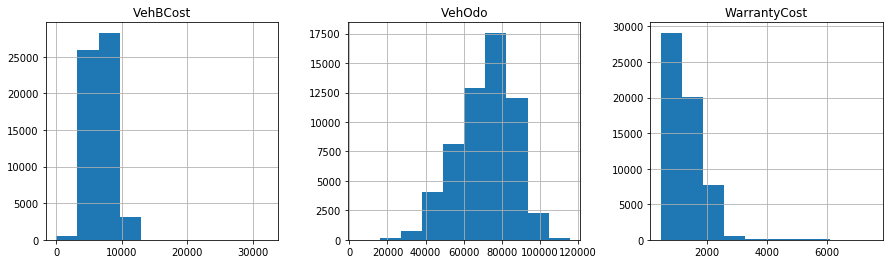

In [109]:
data[['VehOdo', 'VehBCost', 'WarrantyCost']].hist(bins=10, figsize=(15, 4), layout=(1,3))
plt.show()

In [110]:
data['VehOdoBin'] = pd.cut(data['VehOdo'].astype(int), 10, right=False)
data['VehBCostBin'] = pd.cut(data['VehBCost'].astype(int), 10, right=False)
data['WarrantyCostBin'] = pd.cut(data['WarrantyCost'].astype(int), 10, right=False)

data.drop(['VehOdo', 'VehBCost', 'WarrantyCost'], axis=1, inplace=True)

data.head()

,Auction,Trim,Color,Transmission,WheelType,ModelSimple,Doors,USRegion,IsBadBuy,VehicleAge,VehOdoBin,VehBCostBin,WarrantyCostBin
0,ADESA,EX,BLUE,AUTO,COVERS,SPECTRA,4D,South,1,2,"[60271.0, 71360.2)","[3230.9, 6460.8)","[462.0, 1165.6)"
1,MANHEIM,SXT,SILVER,AUTO,COVERS,STRATUS,4D,South,0,3,"[82449.4, 93538.6)","[3230.9, 6460.8)","[1165.6, 1869.2)"
2,OTHER,SE,BLACK,AUTO,COVERS,CALIBER,4D,South,0,2,"[38092.6, 49181.8)","[6460.8, 9690.7)","[462.0, 1165.6)"
3,OTHER,S,BROWN,AUTO,COVERS,FREESTAR,NaN,West,0,4,"[71360.2, 82449.4)","[3230.9, 6460.8)","[1165.6, 1869.2)"
4,MANHEIM,BAS,BLUE,AUTO,ALLOY,TOWN & COUNTRY,NaN,South,0,4,"[71360.2, 82449.4)","[3230.9, 6460.8)","[1165.6, 1869.2)"


### Remapping dei valori

Mappo i valori unici presenti in più colonne nella relativa colonna, o semplicemente cerco di renderli più significativi, per esempio l'attributo OHTER può essere presente sia in Auction che in TopThreeAmericanName, quindi devo distinguerli

In [111]:
data['IsBadBuy'] = data['IsBadBuy'].map(
    {0: 'Good Buy', 1: 'Bad Buy'}).astype(str)

if 'VehicleAge' in data.columns: data['VehicleAge'] = data['VehicleAge'].astype(str) + '_Age'
if 'VehOdoBin' in data.columns: data['VehOdoBin'] = data['VehOdoBin'].astype(str) + '_Odo'
if 'VehBCostBin' in data.columns: data['VehBCostBin'] = data['VehBCostBin'].astype(str) + '_Cost'
if 'WarrantyCostBin' in data.columns: data['WarrantyCostBin'] = data['WarrantyCostBin'].astype(str) + '_Warranty'
if 'Auction' in data.columns: data['Auction'] = data['Auction'].astype(str) + '_Auction'
#if 'TopThreeAmericanName' in data.columns: data['TopThreeAmericanName'] = data['TopThreeAmericanName'].astype(str) + '_TopThreeAmericanName'
if 'ModelSimple' in data.columns: data['ModelSimple'] = data['ModelSimple'].astype(str) + '_ModelSimple'
if 'Trim' in data.columns: data['Trim'] = data['Trim'].astype(str) + '_Trim'
#if 'VNST' in data.columns: data['VNST'] = data['VNST'].astype(str) + '_VNST'
if 'Transmission' in data.columns: data['Transmission'] = data['Transmission'].astype(str) + '_Transmission'
#if 'Make' in data.columns: data['Make'] = data['Make'].astype(str) + '_Make'
if 'WheelType' in data.columns: data['WheelType'] = data['WheelType'].astype(str) + '_WheelType'

data.head()

,Auction,Trim,Color,Transmission,WheelType,ModelSimple,Doors,USRegion,IsBadBuy,VehicleAge,VehOdoBin,VehBCostBin,WarrantyCostBin
0,ADESA_Auction,EX_Trim,BLUE,AUTO_Transmission,COVERS_WheelType,SPECTRA_ModelSimple,4D,South,Bad Buy,2_Age,"[60271.0, 71360.2)_Odo","[3230.9, 6460.8)_Cost","[462.0, 1165.6)_Warranty"
1,MANHEIM_Auction,SXT_Trim,SILVER,AUTO_Transmission,COVERS_WheelType,STRATUS_ModelSimple,4D,South,Good Buy,3_Age,"[82449.4, 93538.6)_Odo","[3230.9, 6460.8)_Cost","[1165.6, 1869.2)_Warranty"
2,OTHER_Auction,SE_Trim,BLACK,AUTO_Transmission,COVERS_WheelType,CALIBER_ModelSimple,4D,South,Good Buy,2_Age,"[38092.6, 49181.8)_Odo","[6460.8, 9690.7)_Cost","[462.0, 1165.6)_Warranty"
3,OTHER_Auction,S_Trim,BROWN,AUTO_Transmission,COVERS_WheelType,FREESTAR_ModelSimple,NaN,West,Good Buy,4_Age,"[71360.2, 82449.4)_Odo","[3230.9, 6460.8)_Cost","[1165.6, 1869.2)_Warranty"
4,MANHEIM_Auction,BAS_Trim,BLUE,AUTO_Transmission,ALLOY_WheelType,TOWN & COUNTRY_ModelSimple,NaN,South,Good Buy,4_Age,"[71360.2, 82449.4)_Odo","[3230.9, 6460.8)_Cost","[1165.6, 1869.2)_Warranty"


### Creazione training e test set

In [112]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=1)

## Applicazione algoritmo dataset originale

### Frequent pattern extraction with different type and support

In [113]:
records = train.values.tolist()

In [114]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

- supp = [0, 100] è la percentuale
- target = {'a', 'c', 'm'} sono quelli che ci interessano
- conf = [0, 100] è la percentuale
- zmin = minimo numero di item in un itemset
- zmax = massimo numero di item in un itemset
- se il target non è r, non guarda neanche il supporto, ma genera solo gli itemset frequenti

In [130]:
targets = ['a', 'c', 'm']
supports = [1, 2, 5, 10, 20]
results = {}
for target in targets:
        results[target] = {}
for target in targets:
    for support in supports:
        results[target][support] = apriori(records, supp=support, zmin=2, target=target, prune=10) 

In [131]:
results_number = {}
for target in targets:
        results_number[target] = {}
for target in targets:
    for support in supports:
        results_number[target][support] = len(results[target][support])

In [132]:
for item in results_number:
    print("With types "+item+" we found (values are % of support)")
    print(str(results_number[item])+'\n')

With types a we found (values are % of support)
{1: 41054, 2: 13953, 5: 3027, 10: 853, 20: 208}

With types c we found (values are % of support)
{1: 36954, 2: 13446, 5: 3018, 10: 853, 20: 208}

With types m we found (values are % of support)
{1: 4779, 2: 1865, 5: 475, 10: 158, 20: 45}



### Assiocation rules extraction with different confidence

Scelgo il miglior valore di supporto da sopra

In [118]:
support = 10

In [119]:
confidences = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {}
for confidence in confidences:
    results[confidence] = {}
for confidence in confidences:
    results[confidence] = apriori(records, supp=support, zmin=2, target='r', conf=confidence, report='lab')
    # l = lift, a = support rules, b = support antecedent

In [120]:
results_number = {}
for confidence in confidences:
        results_number[confidence] = 0
for confidence in confidences:
    results_number[confidence] = len(results[confidence])

In [121]:
for item in results_number:
    print("With confidence "+str(item)+", support "+str(support)+", we found "+str(results_number[item])+" rules")

With confidence 1, support 10, we found 71986 rules
With confidence 2, support 10, we found 51803 rules
With confidence 5, support 10, we found 31882 rules
With confidence 10, support 10, we found 22551 rules
With confidence 20, support 10, we found 12298 rules
With confidence 30, support 10, we found 6829 rules
With confidence 40, support 10, we found 5290 rules
With confidence 50, support 10, we found 3947 rules
With confidence 60, support 10, we found 2475 rules
With confidence 70, support 10, we found 1504 rules
With confidence 80, support 10, we found 1375 rules
With confidence 90, support 10, we found 627 rules
With confidence 100, support 10, we found 0 rules


Scelgo il valore di confidenza che preferisco

In [124]:
best_confidence=90

Le regole hanno il formato (conseguenza, items antecedenti, lift, supporto regola, supporto antecedente)

In [125]:
for item in results[best_confidence]:
    print(item)

('AUTO_Transmission', ('BLACK',), 0.9892197973991049, 4056, 4247)
('AUTO_Transmission', ('GREY',), 1.0036336190989774, 4243, 4379)
('AUTO_Transmission', ('6_Age',), 0.9855052130827545, 4193, 4407)
('Good Buy', ('2_Age', '4D', 'AUTO_Transmission'), 1.068234770555076, 3956, 4222)
('4D', ('2_Age', 'Good Buy', 'AUTO_Transmission'), 1.1072394071245328, 3956, 4353)
('Good Buy', ('2_Age', '4D'), 1.067609918374573, 4008, 4280)
('4D', ('2_Age', 'Good Buy'), 1.1060402285827036, 4008, 4415)
('AUTO_Transmission', ('2_Age', '4D'), 1.0217662984961118, 4222, 4280)
('4D', ('2_Age', 'AUTO_Transmission'), 1.108359323478195, 4222, 4641)
('4D', ('2_Age',), 1.107360420767325, 4280, 4709)
('AUTO_Transmission', ('2_Age', 'Good Buy'), 1.0212570633720526, 4353, 4415)
('Good Buy', ('2_Age', 'AUTO_Transmission'), 1.069315235702358, 4353, 4641)
('Good Buy', ('2_Age',), 1.0688842393567932, 4415, 4709)
('AUTO_Transmission', ('2_Age',), 1.020845437270133, 4641, 4709)
('AUTO_Transmission', ('Bad Buy', '4D'), 1.007193

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eac9c96d0>]],
      dtype=object)

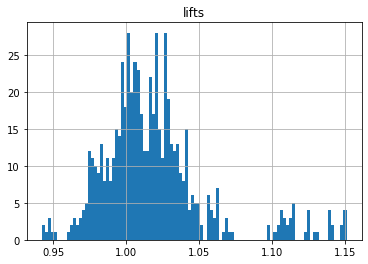

In [126]:
lifts = []
for item in results[best_confidence]:
    lifts.append(item[2])
lifts = pd.DataFrame({"lifts":lifts})
lifts.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f479fe890>]],
      dtype=object)

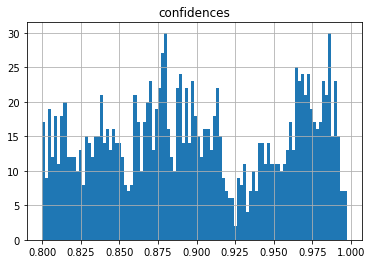

In [41]:
confidences = []
for item in results[best_confidence]:
    confidences.append(item[3]/item[4])
lifts = pd.DataFrame({"confidences":confidences})
lifts.hist(bins=100)

Seleziono solo le regole con lift più alto

In [42]:
best_lift = 2 # mettere un valore leggermente più basso della soglia, perchè uso >

In [43]:
best_rules = []
for item in results[best_confidence]:
    if item[2]>best_lift:
        best_rules.append(item)
best_rules.sort(key= lambda x: x[2], reverse=True)
for rule in best_rules:
    print("(" + str(rule[2]) + ")" + str(rule[1]) + '\t--->\t' + str(rule[0]))

(3.95704922938391)('LS_Trim', 'Good Buy')	--->	CHEVROLET_Make
(3.954953881625313)('LS_Trim', 'Good Buy', 'AUTO_Transmission')	--->	CHEVROLET_Make
(3.9383284662315847)('LS_Trim',)	--->	CHEVROLET_Make
(3.935409238549104)('LS_Trim', 'AUTO_Transmission')	--->	CHEVROLET_Make
(3.9335919430542856)('LS_Trim', '4D', 'Good Buy')	--->	CHEVROLET_Make
(3.9324852981805267)('LS_Trim', '4D', 'Good Buy', 'AUTO_Transmission')	--->	CHEVROLET_Make
(3.907680001116796)('LS_Trim', '4D')	--->	CHEVROLET_Make
(3.905632105533202)('LS_Trim', '4D', 'AUTO_Transmission')	--->	CHEVROLET_Make


### Missing values correction

Tra le regole generate, andiamo a vedere quali sono le migliori che hanno come conseguenza il target is bad but. Vediamo che con il nostro supporto e confidenza le regole più significative per il lift sono (se due regole hanno lo stesso lift e una è contenuta in un altra, scegliamo quella più corta in quanto il paramentro in più non aumenta il lift e quindi è indipendente)

- (1.0457939570042045)('OTHER_Auction', 'Good Buy', 'AUTO_Transmission')	--->	4D
- (1.0178138990874082)('CHEVROLET_Make', 'Good Buy')	--->	AUTO_Transmission
- (1.0153902125615344)('ALLOY_WheelType', 'South', '4D')	--->	AUTO_Transmission

In [36]:
test.head()

,Auction,Make,Trim,Color,Transmission,WheelType,ModelSimple,Doors,USRegion,IsBadBuy,VehicleAge,VehOdoBin,VehBCostBin,WarrantyCostBin
5473,OTHER_Auction,DODGE_Make,SLT_Trim,BLACK,AUTO_Transmission,ALLOY_WheelType,DURANGO_ModelSimple,4D,West,Good Buy,6_Age,"[87191.4, 94812.6)_Odo","[5747.0, 6662.5)_Cost","[2213.2, 2432.1)_Warranty"
51479,MANHEIM_Auction,CHEVROLET_Make,LS_Trim,RED,AUTO_Transmission,ALLOY_WheelType,MALIBU MAXX_ModelSimple,4D,South,Good Buy,6_Age,"[79570.2, 87191.4)_Odo","[4831.5, 5747.0)_Cost","[1337.6, 1556.5)_Warranty"
13192,ADESA_Auction,PONTIAC_Make,BAS_Trim,RED,AUTO_Transmission,ALLOY_WheelType,G6_ModelSimple,4D,West,Good Buy,3_Age,"[56706.6, 64327.8)_Odo","[7578.0, 8493.5)_Cost","[899.8, 1118.7)_Warranty"
35520,MANHEIM_Auction,DODGE_Make,BAS_Trim,WHITE,AUTO_Transmission,COVERS_WheelType,CHARGER_ModelSimple,4D,South,Good Buy,3_Age,"[71949.0, 79570.2)_Odo","[9409.0, 10324.5)_Cost","[1337.6, 1556.5)_Warranty"
10216,MANHEIM_Auction,CHEVROLET_Make,LT_Trim,SILVER,AUTO_Transmission,ALLOY_WheelType,MALIBU_ModelSimple,4D,South,Good Buy,3_Age,"[71949.0, 79570.2)_Odo","[4831.5, 5747.0)_Cost","[899.8, 1118.7)_Warranty"


In [37]:
#(1.0457939570042045)('OTHER_Auction', 'Good Buy', 'AUTO_Transmission')	--->	4D # 96.4%
#(1.0424895476541323)('OTHER_Auction', 'AUTO_Transmission')	--->	4D # 96%
#(1.0389772632959253)('OTHER_Auction', 'Good Buy')	--->	4D # 95.7%
#(1.0362230260805088)('OTHER_Auction',)	--->	4D # 95.4%
condition = (test['Auction']=='OTHER_Auction')&(test['IsBadBuy']=='Good Buy')&(test['Transmission']=='AUTO_Transmission')
consequence_value = '4D'
consequence_column = 'Doors'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 96.4%


In [38]:
# - (1.0178138990874082)('CHEVROLET_Make', 'Good Buy') ---> AUTO_Transmission
condition = (test['Make']=='CHEVROLET_Make')&(test['IsBadBuy']=='Good Buy')
consequence_value = 'AUTO_Transmission'
consequence_column = 'Transmission'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 97.9%


In [39]:
# - (1.0153902125615344)('ALLOY_WheelType', 'South', '4D') ---> AUTO_Transmission
condition = (test['WheelType']=='ALLOY_WheelType')&(test['USRegion']=='South')&(test['Doors']=='4D')
consequence_value = 'AUTO_Transmission'
consequence_column = 'Transmission'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 98.2%


### Accuracy on target

Tra le regole generate, andiamo a vedere quali sono le migliori che hanno come conseguenza il target is bad but. Vediamo che con il nostro supporto e confidenza le regole più significative per il lift sono

- (1.0465983436000288)('3_Age',)	--->	Good Buy
- (1.031258600656461)('CHEVROLET_Make', 'AUTO_Transmission')	--->	Good Buy

In [40]:
# - (1.0153902125615344)('ALLOY_WheelType', 'South', '4D') ---> AUTO_Transmission
condition = (test['VehicleAge']=='3_Age')
consequence_value = 'Good Buy'
consequence_column = 'IsBadBuy'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 91.6%


In [41]:
# - (1.031258600656461)('CHEVROLET_Make', 'AUTO_Transmission')	--->	Good Buy
condition = (test['Make']=='CHEVROLET_Make')&(test['Transmission']=='AUTO_Transmission')
consequence_value = 'Good Buy'
consequence_column = 'IsBadBuy'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 90.7%


In [42]:
# - (1.0292970383525062)('COVERS_WheelType', 'MANHEIM_Auction')	--->	Good Buy
condition = (test['WheelType']=='COVERS_WheelType')&(test['Auction']=='MANHEIM_Auction')
consequence_value = 'Good Buy'
consequence_column = 'IsBadBuy'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 90.3%


## AR con dataset bilanciato

### Preparazione dataset

In [44]:
data.head()

,Auction,Make,Trim,Color,Transmission,WheelType,ModelSimple,Doors,USRegion,IsBadBuy,VehicleAge,VehOdoBin,VehBCostBin,WarrantyCostBin
0,ADESA_Auction,KIA_Make,EX_Trim,BLUE,AUTO_Transmission,COVERS_WheelType,SPECTRA_ModelSimple,4D,South,Bad Buy,2_Age,"[60271.0, 71360.2)_Odo","[3230.9, 6460.8)_Cost","[462.0, 1165.6)_Warranty"
1,MANHEIM_Auction,DODGE_Make,SXT_Trim,SILVER,AUTO_Transmission,COVERS_WheelType,STRATUS_ModelSimple,4D,South,Good Buy,3_Age,"[82449.4, 93538.6)_Odo","[3230.9, 6460.8)_Cost","[1165.6, 1869.2)_Warranty"
2,OTHER_Auction,DODGE_Make,SE_Trim,BLACK,AUTO_Transmission,COVERS_WheelType,CALIBER_ModelSimple,4D,South,Good Buy,2_Age,"[38092.6, 49181.8)_Odo","[6460.8, 9690.7)_Cost","[462.0, 1165.6)_Warranty"
3,OTHER_Auction,FORD_Make,S_Trim,BROWN,AUTO_Transmission,COVERS_WheelType,FREESTAR_ModelSimple,NaN,West,Good Buy,4_Age,"[71360.2, 82449.4)_Odo","[3230.9, 6460.8)_Cost","[1165.6, 1869.2)_Warranty"
4,MANHEIM_Auction,CHRYSLER_Make,BAS_Trim,BLUE,AUTO_Transmission,ALLOY_WheelType,TOWN & COUNTRY_ModelSimple,NaN,South,Good Buy,4_Age,"[71360.2, 82449.4)_Odo","[3230.9, 6460.8)_Cost","[1165.6, 1869.2)_Warranty"


In [45]:
good_buy = data[data['IsBadBuy']=='Good Buy']
bad_buy = data[data['IsBadBuy']=='Bad Buy']

good_buy_undersamp =  resample(good_buy,
                                replace = False, # sample without replacement
                                n_samples = len(bad_buy), # match minority n
                                random_state = 42) # reproducible results

data = pd.concat([good_buy_undersamp, bad_buy])
data.IsBadBuy.value_counts()

Bad Buy     7104
Good Buy    7104
Name: IsBadBuy, dtype: int64

In [46]:
train, test = train_test_split(data, test_size=0.3, random_state=1)

### Frequent pattern extraction with different type and support

In [47]:
records = train.values.tolist()

In [48]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

In [49]:
targets = ['a', 'c', 'm', 'g']
supports = [1, 2, 5, 10, 20]
results = {}
for target in targets:
        results[target] = {}
for target in targets:
    for support in supports:
        results[target][support] = apriori(records, supp=support, zmin=2, target=target) 

In [50]:
results_number = {}
for target in targets:
        results_number[target] = {}
for target in targets:
    for support in supports:
        results_number[target][support] = len(results[target][support])

In [51]:
for item in results_number:
    print("With types "+item+" we found (values are % of support)")
    print(str(results_number[item])+'\n')

With types a we found (values are % of support)
{1: 49770, 2: 14971, 5: 2867, 10: 719, 20: 156}

With types c we found (values are % of support)
{1: 40631, 2: 13971, 5: 2847, 10: 719, 20: 156}

With types m we found (values are % of support)
{1: 7724, 2: 2862, 5: 657, 10: 184, 20: 46}

With types g we found (values are % of support)
{1: 40596, 2: 13954, 5: 2845, 10: 719, 20: 156}



### Assiocation rules extraction with different confidence

Scelgo il miglior valore di supporto da sopra

In [58]:
support = 1

In [59]:
confidences = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {}
for confidence in confidences:
    results[confidence] = {}
for confidence in confidences:
    results[confidence] = apriori(records, supp=support, zmin=2, target='r', conf=confidence, report='lab')
    # l = lift, a = support rules, b = support antecedent

In [60]:
results_number = {}
for confidence in confidences:
        results_number[confidence] = 0
for confidence in confidences:
    results_number[confidence] = len(results[confidence])

In [61]:
for item in results_number:
    print("With confidence "+str(item)+", support "+str(support)+", we found "+str(results_number[item])+" rules")

With confidence 1, support 1, we found 3211989 rules
With confidence 2, support 1, we found 2559627 rules
With confidence 5, support 1, we found 1732291 rules
With confidence 10, support 1, we found 1234757 rules
With confidence 20, support 1, we found 739915 rules
With confidence 30, support 1, we found 450513 rules
With confidence 40, support 1, we found 322090 rules
With confidence 50, support 1, we found 235233 rules
With confidence 60, support 1, we found 150340 rules
With confidence 70, support 1, we found 89267 rules
With confidence 80, support 1, we found 63079 rules
With confidence 90, support 1, we found 42364 rules
With confidence 100, support 1, we found 12451 rules


Scelgo il valore di confidenza che preferisco

In [62]:
best_confidence=100

Le regole hanno il formato (conseguenza, items antecedenti, lift, supporto regola, supporto antecedente)

In [63]:
for item in results[best_confidence]:
    print(item)

('AUTO_Transmission', ('BUICK_Make', '4D'), 1.03475184684216, 100, 100)
('4D', ('BUICK_Make', 'AUTO_Transmission'), 1.2320366699702676, 100, 100)
('4D', ('BUICK_Make',), 1.2320366699702676, 100, 100)
('AUTO_Transmission', ('BUICK_Make',), 1.03475184684216, 100, 100)
('AUTO_Transmission', ('UPLANDER_ModelSimple', nan, 'CHEVROLET_Make'), 1.03475184684216, 102, 102)
('CHEVROLET_Make', ('UPLANDER_ModelSimple', nan, 'AUTO_Transmission'), 4.604166666666667, 102, 102)
(nan, ('UPLANDER_ModelSimple', 'CHEVROLET_Make', 'AUTO_Transmission'), 7.328666175386883, 102, 102)
('CHEVROLET_Make', ('UPLANDER_ModelSimple', nan), 4.604166666666667, 102, 102)
(nan, ('UPLANDER_ModelSimple', 'CHEVROLET_Make'), 7.328666175386883, 102, 102)
('AUTO_Transmission', ('UPLANDER_ModelSimple', nan), 1.03475184684216, 102, 102)
(nan, ('UPLANDER_ModelSimple', 'AUTO_Transmission'), 7.328666175386883, 102, 102)
(nan, ('UPLANDER_ModelSimple',), 7.328666175386883, 102, 102)
('AUTO_Transmission', ('UPLANDER_ModelSimple', 'CHE

('[462.0, 1165.6)_Warranty', ('COBALT_ModelSimple', 'CHEVROLET_Make', 'MANHEIM_Auction'), 2.0551766893986363, 108, 108)
('CHEVROLET_Make', ('COBALT_ModelSimple', '[462.0, 1165.6)_Warranty', 'MANHEIM_Auction'), 4.604166666666667, 108, 108)
('[462.0, 1165.6)_Warranty', ('COBALT_ModelSimple', 'CHEVROLET_Make', 'South', '4D', 'AUTO_Transmission'), 2.0551766893986363, 102, 102)
('CHEVROLET_Make', ('COBALT_ModelSimple', '[462.0, 1165.6)_Warranty', 'South', '4D', 'AUTO_Transmission'), 4.604166666666667, 102, 102)
('[462.0, 1165.6)_Warranty', ('COBALT_ModelSimple', 'CHEVROLET_Make', 'South', '4D'), 2.0551766893986363, 107, 107)
('CHEVROLET_Make', ('COBALT_ModelSimple', '[462.0, 1165.6)_Warranty', 'South', '4D'), 4.604166666666667, 107, 107)
('[462.0, 1165.6)_Warranty', ('COBALT_ModelSimple', 'CHEVROLET_Make', 'South', 'AUTO_Transmission'), 2.0551766893986363, 129, 129)
('CHEVROLET_Make', ('COBALT_ModelSimple', '[462.0, 1165.6)_Warranty', 'South', 'AUTO_Transmission'), 4.604166666666667, 129, 1

('DODGE_Make', ('DURANGO_ModelSimple', 'Good Buy', 'ALLOY_WheelType', 'AUTO_Transmission'), 5.761877172653534, 117, 117)
('DODGE_Make', ('DURANGO_ModelSimple', 'Good Buy', 'ALLOY_WheelType'), 5.761877172653534, 117, 117)
('AUTO_Transmission', ('DURANGO_ModelSimple', 'DODGE_Make', 'Good Buy', '4D'), 1.03475184684216, 140, 140)
('4D', ('DURANGO_ModelSimple', 'DODGE_Make', 'Good Buy', 'AUTO_Transmission'), 1.2320366699702676, 140, 140)
('DODGE_Make', ('DURANGO_ModelSimple', 'Good Buy', '4D', 'AUTO_Transmission'), 5.761877172653534, 140, 140)
('4D', ('DURANGO_ModelSimple', 'DODGE_Make', 'Good Buy'), 1.2320366699702676, 140, 140)
('DODGE_Make', ('DURANGO_ModelSimple', 'Good Buy', '4D'), 5.761877172653534, 140, 140)
('AUTO_Transmission', ('DURANGO_ModelSimple', 'DODGE_Make', 'Good Buy'), 1.03475184684216, 140, 140)
('DODGE_Make', ('DURANGO_ModelSimple', 'Good Buy', 'AUTO_Transmission'), 5.761877172653534, 140, 140)
('DODGE_Make', ('DURANGO_ModelSimple', 'Good Buy'), 5.761877172653534, 140, 1

('CHEVROLET_Make', ('LT_Trim', '3_Age', '[6460.8, 9690.7)_Cost', 'AUTO_Transmission'), 4.604166666666667, 106, 106)
('CHEVROLET_Make', ('LT_Trim', '3_Age', '[6460.8, 9690.7)_Cost'), 4.604166666666667, 106, 106)
('CHEVROLET_Make', ('LT_Trim', '3_Age', 'ALLOY_WheelType'), 4.604166666666667, 100, 100)
('CHEVROLET_Make', ('LT_Trim', '3_Age', '4D', 'AUTO_Transmission'), 4.604166666666667, 143, 143)
('CHEVROLET_Make', ('LT_Trim', '3_Age', '4D'), 4.604166666666667, 144, 144)
('CHEVROLET_Make', ('LT_Trim', '3_Age', 'AUTO_Transmission'), 4.604166666666667, 154, 154)
('CHEVROLET_Make', ('LT_Trim', '3_Age'), 4.604166666666667, 155, 155)
('AUTO_Transmission', ('LT_Trim', '3_Age', '[6460.8, 9690.7)_Cost', '4D'), 1.03475184684216, 100, 100)
('AUTO_Transmission', ('LT_Trim', '3_Age', '[6460.8, 9690.7)_Cost'), 1.03475184684216, 106, 106)
('CHEVROLET_Make', ('LT_Trim', '4_Age', '4D', 'AUTO_Transmission'), 4.604166666666667, 110, 110)
('CHEVROLET_Make', ('LT_Trim', '4_Age', '4D'), 4.604166666666667, 112

('DODGE_Make', ('SXT_Trim', '[462.0, 1165.6)_Warranty', '4D', 'AUTO_Transmission'), 5.761877172653534, 290, 290)
('DODGE_Make', ('SXT_Trim', '[462.0, 1165.6)_Warranty', '4D'), 5.761877172653534, 296, 296)
('DODGE_Make', ('SXT_Trim', '[462.0, 1165.6)_Warranty', 'AUTO_Transmission'), 5.761877172653534, 299, 299)
('DODGE_Make', ('SXT_Trim', '[462.0, 1165.6)_Warranty'), 5.761877172653534, 305, 305)
('DODGE_Make', ('SXT_Trim', '[3230.9, 6460.8)_Cost', 'Bad Buy', 'ALLOY_WheelType'), 5.761877172653534, 102, 102)
('DODGE_Make', ('SXT_Trim', '[3230.9, 6460.8)_Cost', 'Bad Buy', '4D', 'AUTO_Transmission'), 5.761877172653534, 141, 141)
('DODGE_Make', ('SXT_Trim', '[3230.9, 6460.8)_Cost', 'Bad Buy', '4D'), 5.761877172653534, 144, 144)
('DODGE_Make', ('SXT_Trim', '[3230.9, 6460.8)_Cost', 'Bad Buy', 'AUTO_Transmission'), 5.761877172653534, 156, 156)
('DODGE_Make', ('SXT_Trim', '[3230.9, 6460.8)_Cost', 'Bad Buy'), 5.761877172653534, 159, 159)
('AUTO_Transmission', ('SXT_Trim', 'DODGE_Make', '[3230.9, 

('AUTO_Transmission', ('IMPALA_ModelSimple', 'OTHER_Auction', '[6460.8, 9690.7)_Cost', '4D'), 1.03475184684216, 107, 107)
('4D', ('IMPALA_ModelSimple', 'OTHER_Auction', '[6460.8, 9690.7)_Cost', 'AUTO_Transmission'), 1.2320366699702676, 107, 107)
('4D', ('IMPALA_ModelSimple', 'OTHER_Auction', '[6460.8, 9690.7)_Cost'), 1.2320366699702676, 107, 107)
('AUTO_Transmission', ('IMPALA_ModelSimple', 'OTHER_Auction', '[6460.8, 9690.7)_Cost'), 1.03475184684216, 107, 107)
('AUTO_Transmission', ('IMPALA_ModelSimple', 'OTHER_Auction', '4D'), 1.03475184684216, 152, 152)
('4D', ('IMPALA_ModelSimple', 'OTHER_Auction', 'AUTO_Transmission'), 1.2320366699702676, 152, 152)
('4D', ('IMPALA_ModelSimple', 'OTHER_Auction'), 1.2320366699702676, 152, 152)
('AUTO_Transmission', ('IMPALA_ModelSimple', 'OTHER_Auction'), 1.03475184684216, 152, 152)
('AUTO_Transmission', ('IMPALA_ModelSimple', 'West', '[6460.8, 9690.7)_Cost', '4D'), 1.03475184684216, 117, 117)
('4D', ('IMPALA_ModelSimple', 'West', '[6460.8, 9690.7)_C

('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', '[462.0, 1165.6)_Warranty', 'ALLOY_WheelType', '4D'), 1.03475184684216, 106, 106)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', '[462.0, 1165.6)_Warranty', 'ALLOY_WheelType'), 1.03475184684216, 110, 110)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', 'Bad Buy', 'South', '4D'), 1.03475184684216, 124, 124)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', 'Bad Buy', 'South'), 1.03475184684216, 134, 134)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', 'Bad Buy', '4D'), 1.03475184684216, 193, 193)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', 'Bad Buy'), 1.03475184684216, 208, 208)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', 'Good Buy', 'ALLOY_WheelType', '4D'), 1.03475184684216, 163, 163)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', 'Good Buy', 'ALLOY_WheelType'), 1.03475184684216, 173, 173)
('AUTO_Transmission', ('2_Age', '[6460.8, 9690.7)_Cost', 'ALLOY_WheelT

('AUTO_Transmission', ('WHITE', 'OTHER_Auction', 'Bad Buy', '4D'), 1.03475184684216, 168, 168)
('AUTO_Transmission', ('WHITE', 'OTHER_Auction', 'ALLOY_WheelType', '4D'), 1.03475184684216, 158, 158)
('AUTO_Transmission', ('WHITE', 'OTHER_Auction', 'South', '4D'), 1.03475184684216, 194, 194)
('AUTO_Transmission', ('WHITE', 'West', '[6460.8, 9690.7)_Cost', 'Good Buy', '4D'), 1.03475184684216, 102, 102)
('AUTO_Transmission', ('WHITE', 'West', '[6460.8, 9690.7)_Cost', 'ALLOY_WheelType', '4D'), 1.03475184684216, 109, 109)
('AUTO_Transmission', ('WHITE', 'West', '[6460.8, 9690.7)_Cost', 'MANHEIM_Auction'), 1.03475184684216, 113, 113)
('AUTO_Transmission', ('WHITE', 'West', '[6460.8, 9690.7)_Cost', '4D'), 1.03475184684216, 174, 174)
('AUTO_Transmission', ('WHITE', '[71360.2, 82449.4)_Odo', '[6460.8, 9690.7)_Cost', 'Good Buy', '4D'), 1.03475184684216, 105, 105)
('AUTO_Transmission', ('WHITE', '[71360.2, 82449.4)_Odo', '[6460.8, 9690.7)_Cost', 'ALLOY_WheelType', '4D'), 1.03475184684216, 130, 130

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eacab9ad0>]],
      dtype=object)

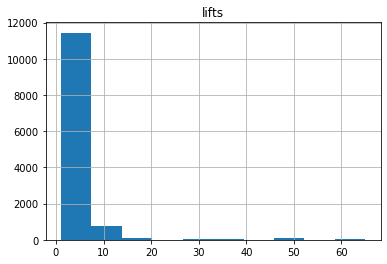

In [64]:
lifts = []
for item in results[best_confidence]:
    lifts.append(item[2])
lifts = pd.DataFrame({"lifts":lifts})
lifts.hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eacab9590>]],
      dtype=object)

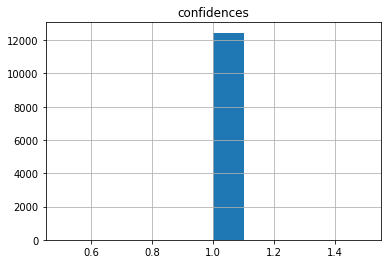

In [65]:
confidences = []
for item in results[best_confidence]:
    confidences.append(item[3]/item[4])
lifts = pd.DataFrame({"confidences":confidences})
lifts.hist(bins=10)

Seleziono solo le regole con lift più alto

In [66]:
best_lift = 20 # mettere un valore leggermente più basso della soglia, perchè uso >

In [67]:
best_rules = []
for item in results[best_confidence]:
    if item[2]>best_lift:
        best_rules.append(item)
best_rules.sort(key= lambda x: x[2], reverse=True)
for rule in best_rules:
    print("(" + str(rule[2]) + ")" + str(rule[1]) + '\t--->\t' + str(rule[0]))

(65.0)('2_Trim', 'SATURN_Make', '[462.0, 1165.6)_Warranty', '[3230.9, 6460.8)_Cost')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make', '[462.0, 1165.6)_Warranty', '4D')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make', '[462.0, 1165.6)_Warranty')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make', '[3230.9, 6460.8)_Cost', '4D')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make', '[3230.9, 6460.8)_Cost', 'AUTO_Transmission')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make', '[3230.9, 6460.8)_Cost')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make', '4D')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make', 'AUTO_Transmission')	--->	ION_ModelSimple
(65.0)('2_Trim', 'SATURN_Make')	--->	ION_ModelSimple
(65.0)('2_Trim', '[462.0, 1165.6)_Warranty', '[3230.9, 6460.8)_Cost')	--->	ION_ModelSimple
(65.0)('2_Trim', '[462.0, 1165.6)_Warranty', '4D')	--->	ION_ModelSimple
(65.0)('2_Trim', '[462.0, 1165.6)_Warranty')	--->	ION_ModelSimple
(65.0)('2_Trim', '[3230.9, 6460.8)_Cost', '4D')	--

### Missing values correction

Tra le regole generate, andiamo a vedere quali sono le migliori che hanno come conseguenza il target is bad but. Vediamo che con il nostro supporto e confidenza le regole più significative per il lift sono (se due regole hanno lo stesso lift e una è contenuta in un altra, scegliamo quella più corta in quanto il paramentro in più non aumenta il lift e quindi è indipendente)

- (1.0814969930788634)('[462.0, 680.9)_Warranty',)	--->	4D
- (4.364421812148303)('LS_Trim',)	--->	CHEVROLET_Make
- (1.053859954079775)('GREY',)	--->	4D

In [63]:
test.head()

,Auction,Make,Trim,Color,Transmission,WheelType,ModelSimple,Doors,USRegion,IsBadBuy,VehicleAge,VehOdoBin,VehBCostBin,WarrantyCostBin
24678,MANHEIM_Auction,FORD_Make,SE_Trim,GREY,AUTO_Transmission,ALLOY_WheelType,TAURUS_ModelSimple,4D,South,Good Buy,5_Age,"[94812.6, 102433.8)_Odo","[3916.0, 4831.5)_Cost","[1118.7, 1337.6)_Warranty"
32141,OTHER_Auction,CHEVROLET_Make,LS_Trim,RED,AUTO_Transmission,COVERS_WheelType,IMPALA_ModelSimple,4D,West,Bad Buy,1_Age,"[79570.2, 87191.4)_Odo","[7578.0, 8493.5)_Cost","[1994.3, 2213.2)_Warranty"
43856,ADESA_Auction,CHRYSLER_Make,TOU_Trim,SILVER,AUTO_Transmission,ALLOY_WheelType,PT CRUISER_ModelSimple,4D,South,Bad Buy,4_Age,"[71949.0, 79570.2)_Odo","[5747.0, 6662.5)_Cost","[1337.6, 1556.5)_Warranty"
38368,MANHEIM_Auction,CHEVROLET_Make,LS_Trim,YELLOW,MANUAL_Transmission,COVERS_WheelType,COBALT_ModelSimple,2D,West,Good Buy,3_Age,"[64327.8, 71949.0)_Odo","[4831.5, 5747.0)_Cost","[680.9, 899.8)_Warranty"
56937,MANHEIM_Auction,CHEVROLET_Make,BAS_Trim,GOLD,AUTO_Transmission,COVERS_WheelType,IMPALA_ModelSimple,4D,South,Good Buy,4_Age,"[64327.8, 71949.0)_Odo","[5747.0, 6662.5)_Cost","[1556.5, 1775.4)_Warranty"


In [72]:
# (1.0814969930788634)('[462.0, 680.9)_Warranty',)	--->	4D
condition = (test['WarrantyCostBin']=='[462.0, 680.9)_Warranty')
consequence_value = '4D'
consequence_column = 'Doors'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 93.9%


In [73]:
#(4.364421812148303)('LS_Trim',)	--->	CHEVROLET_Make
condition = (test['Trim']=='LS_Trim')
consequence_value = 'CHEVROLET_Make'
consequence_column = 'Make'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 93.3%


In [74]:
#(1.053859954079775)('GREY',)	--->	4D
condition = (test['Color']=='GREY')
consequence_value = '4D'
consequence_column = 'Doors'
results = test[condition][consequence_column].value_counts()
good = results[consequence_value]
bad = 0
for column in results.keys():
    if column != consequence_value:
        bad += results[column]
print("Accuracy is "+str((good/(good+bad))*100)[:4]+"%")

Accuracy is 95.8%


### Accuracy On Target

Con il dataset bilanciato, non si ottengono regole per quanto riguarda la classe come target